<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch6-TD_Learning/MarkovRandomProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

## Markov Random Process

This is an example of the markov random process Example 6.2 in page-125 from the book ["Reinforcement Learning" by Barto, Sutton](http://incompleteideas.net/sutton/book/the-book.html).

Given a markov random process given by the following image. There are 5 states and the transitions happen to neighboring states at every step with equal probability. The probability of making a transition to the right from state $E$ has a reward of 1 and terminates the process while all other transitions have a zero reward. A transition to the left from state $A$ also terminates the process but with zero reward

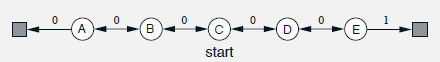

### True State Value Function

This section solves Exercise 6.6 from the book where the true values of the states of the above process is computed. Two approaches are discussed.

#### Linear Algebra Approach
In this approach, the state value function is computed through the adjacency matrix of the above network and solved using the state dynamics. The state dynamics is described below:
$$ \begin{align*} \left[ \begin{matrix} V_A \\ V_B \\ V_C \\ V_D \\ V_E   \end{matrix} \right] &= \left[ \begin{matrix} 0 && 0.5 && 0 && 0 && 0 \\ 0.5 && 0 && 0.5 && 0 && 0 \\ 0 && 0.5 && 0 && 0.5 && 0 \\ 0 && 0 && 0.5 && 0 && 0.5 \\ 0 && 0 && 0 && 0.5 && 0  \end{matrix} \right] \left[ \begin{matrix} V_A \\ V_B \\ V_C \\ V_D \\ V_E   \end{matrix} \right] + \left[ \begin{matrix} 0 \\ 0 \\ 0 \\ 0 \\ 0.5   \end{matrix} \right] \\ V &= A V + b \\ \Rightarrow (I&-A)V = b \\ \Rightarrow V &= (I-A)^{-1} b\end{align*} $$


In [2]:
nodes = 5
A = np.matrix(np.zeros((nodes,nodes)))
b = np.matrix(np.zeros((nodes,1)))
b[-1,-1] = 0.5
for i in range(nodes-1):
  A[i,i+1] = 0.5
  A[i+1,i] = 0.5

V_linalg = np.matmul(np.linalg.inv(np.eye(nodes)-A),b).T
print('Solution using Linear Algebra approach')
print(V_linalg)

Solution using Linear Algebra approach
[[0.16666667 0.33333333 0.5        0.66666667 0.83333333]]


#### Dynamic Programming Approach
This approach is similar to the approach discussed in Chapter-4 pertaining to iterative policy evaluation where the value for each state in the current iteration is calculated from the values of the neighboring states from the previous iteration based on the state transition dynamics. 

In [3]:
num_iters = 100
V_dp = np.zeros((nodes+1,))
V_dp[-1] = 1
for n in range(num_iters):
  for i in range(nodes): 
    V_dp[i] = 0
    if i > 0:
      V_dp[i] = 0.5*V_dp[i-1]
    V_dp[i] += 0.5*V_dp[i+1]

print('Solution using Dynamic Programming approach')
print(V_dp[:-1])

Solution using Dynamic Programming approach
[0.16666667 0.33333333 0.5        0.66666667 0.83333333]


### TD Prediction

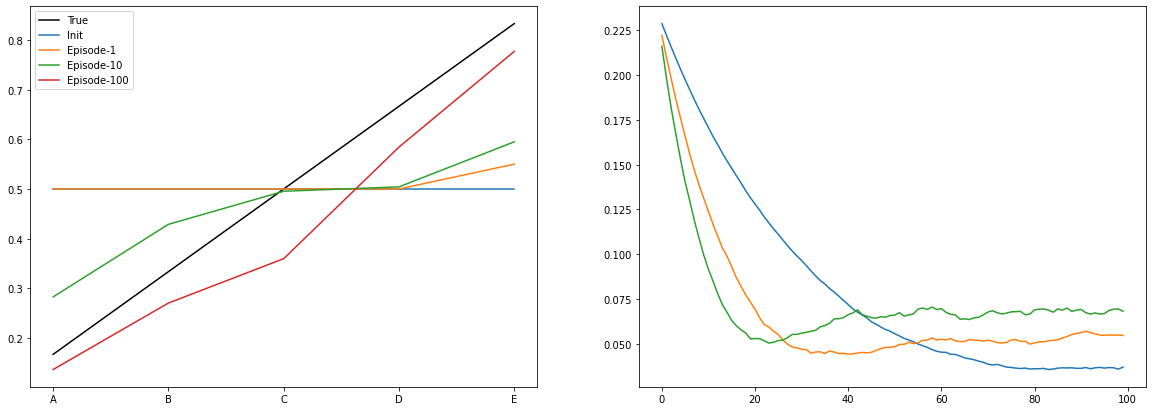

In [4]:
step_size = [0.05,0.1,0.15]
gamma = 1
V_mc = np.zeros((nodes,))
num_episodes = 100

def TD_predict(V_td,alpha,init=None):
  if init == None:
    init = np.random.choice(np.arange(1,nodes+1))
  curr = init
  while True:
    next = np.random.choice([curr-1,curr+1])
    reward = 0
    if next == nodes+1:
      reward = 1
    V_td[curr] += alpha*(reward + gamma*V_td[next] - V_td[curr])
    if next <= 0 or next >= nodes+1:
      break
    curr = next
  return V_td

def MonteCarlo(num_episodes,alpha,firstVisit=True):
  curr = init
  count = np.zeros((nodes+2,))
  value = np.zeros((nodes+2,))
  traj = []
  reward = 0
  while True:
    traj.append(curr)
    next = np.random.choice([curr-1,curr+1])
    if next == nodes+1:
      reward = 1
    if next <= 0 or next >= nodes+1:
      break
    curr = next
  for i in range(1,nodes+1):
    idx = np.where(traj == i)[0]
    if len(idx) > 0:
      if firstVisit:
        count[i] = 1
        value[i] = reward
      else:
        count[i] = float(len(idx))
        value[i] = count[i]*reward
  return count,value

def reset_Vtd():
  V_td = 0.5*np.ones((nodes+2,))
  V_td[0] = 0
  V_td[-1] = 0
  return V_td

V_td = reset_Vtd()
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(np.arange(nodes),V_dp[:-1],'k')
ax[0].plot(np.arange(nodes),V_td[1:-1])

num_runs = 2
init = 1 ### start at state A
for i in range(num_episodes):
  V_td = TD_predict(V_td,0.1,init)
  if i+1 in [1,10]:
    ax[0].plot(np.arange(nodes),V_td[1:-1])
ax[0].plot(np.arange(nodes),V_td[1:-1])
ax[0].legend(['True','Init','Episode-1','Episode-10','Episode-100'])
ax[0].set_xticks(np.arange(nodes));
ax[0].set_xticklabels(['A','B','C','D','E']);

num_runs = 100
num_episodes = 100
error = []
for a in step_size:
  rms = np.zeros((num_runs,num_episodes))
  for i in range(num_runs):
    V_td = reset_Vtd()
    for j in range(num_episodes):
      V_td = TD_predict(V_td,a,None)
      rms[i,j] = np.sqrt(np.mean((V_td[1:-1]-V_dp[:-1])**2))
  avg = np.mean(rms,axis=0)
  ax[1].plot(np.arange(num_episodes),avg)

In [5]:
print(np.sqrt(np.mean((V_td[1:-1]-V_dp[:-1])**2)))

0.041960629326963
